In [1]:
import tqdm

In [2]:
from directed_graph.graph import Graph, load_graph

graph = Graph()

## Построение графа из триплетов

In [3]:
import csv

paths = [
    '/home/simon/Desktop/concept-tree/concept-tree/process_graph/articles_triples_cleaned/arxiv-txt-cs/cs.AI/2502.20639v1.txt',
    '/home/simon/Desktop/concept-tree/concept-tree/process_graph/articles_triples_cleaned/arxiv-txt-cs/cs.AI/2502.20682v1.txt',
    '/home/simon/Desktop/concept-tree/concept-tree/process_graph/articles_triples_cleaned/arxiv-txt-cs/cs.AI/2503.00124v1.txt',
]

added_edges = set()

# MAX_EDGES_COUNT =50

for path in paths:
    with open(path, newline='') as csvfile:
        triplets_reader = csv.reader(csvfile, delimiter=';')
        for triplet in triplets_reader:
            # if MAX_EDGES_COUNT<=0:
                # break
            # MAX_EDGES_COUNT-=1
            agent_1, action, agent_2 = triplet
            edge = (agent_1, agent_2, action)
            if len(agent_1) == 0 or len(agent_2) == 0 or len(action) == 0:
                continue

            if edge not in added_edges:
                added_edges.add(edge)
                if edge[0] not in graph.vertices:
                    graph.add_vertex(edge[0], edge[0].split()[:3])
                if edge[1] not in graph.vertices:
                    graph.add_vertex(edge[1], edge[1].split()[:3])
                graph.add_edge(*edge)

## Перебор параметров для кластеризации ребер

### Получение верхней оценки на eps в переборе

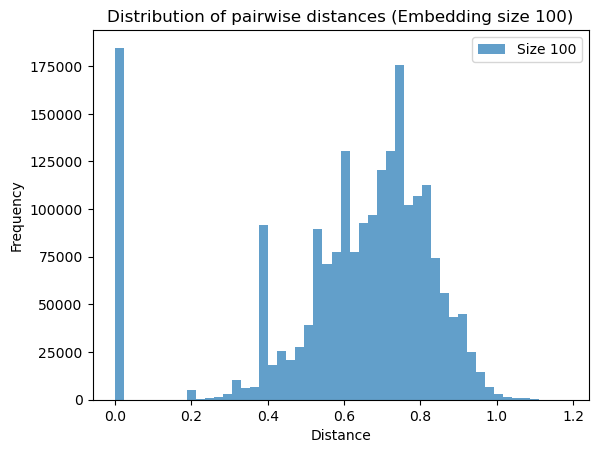

Embedding size 100: Median distance = 0.6792, 90th percentile = 0.8457


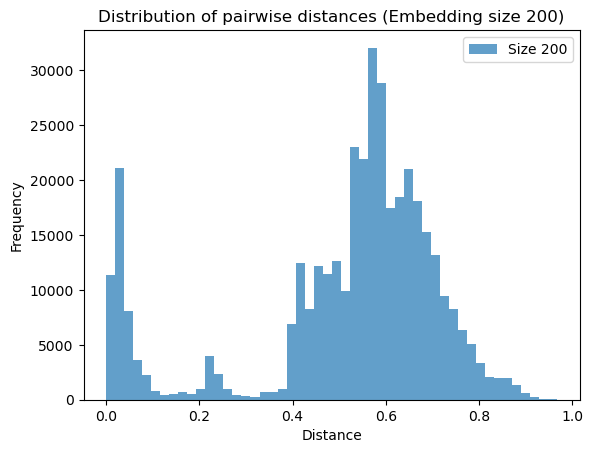

Embedding size 200: Median distance = 0.5708, 90th percentile = 0.7207


{100: {'median_distance': np.float32(0.67924243),
  'percentile_90': np.float32(0.8457414)},
 200: {'median_distance': np.float32(0.57080513),
  'percentile_90': np.float32(0.72070324)}}

In [4]:
from process_graph.edges_clustering import analyze_distance_distributions

analyze_distance_distributions(graph.edges)

In [5]:
unique_labels = set()
for edge in graph.edges:
    unique_labels.add(edge.label)
len(unique_labels)

728

In [6]:
from process_graph.edges_clustering import grid_search_cluster_params
import numpy as np

# Параметры для перебора
embedding_sizes = [100, 200]  # Размерности эмбеддингов
eps_values = np.linspace(0.1, 1, 20)  # Значения eps
min_samples_values = np.linspace(20, 200, 20, dtype=np.int64) # Значения min_samples

# Поиск оптимальных параметров
best_params, best_scores = grid_search_cluster_params(graph.edges, embedding_sizes, eps_values, min_samples_values, optimal_cluster_range=(2, 180), standardize=True)

Embedding size 100, eps=0.1000, min_samples=124: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=133: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=143: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=152: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=162: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=171: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=181: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=190: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1000, min_samples=200: Skipping due to infinite or undefined metric values.
Embedding size 100, eps=0.1474, min_samples=124: Skipping due to infinite or undef

In [9]:
best_params

{100: {'eps': np.float64(0.1), 'min_samples': np.int64(114)},
 200: {'eps': np.float64(0.1), 'min_samples': np.int64(86)}}

In [11]:
best_scores

{100: {'Silhouette Score': np.float32(0.3218826),
  'Davies-Bouldin Index': np.float64(0.9634982527051519),
  'Calinski-Harabasz Index': np.float32(440.59424),
  'Dunn Index': np.float32(29878568.0),
  'Connectivity Score': 0.0,
  'Intra-Cluster Variance': np.float32(9.348879e-12),
  'Noise Ratio': 0.66455078125,
  'Cluster Count Penalty': 0},
 200: {'Silhouette Score': np.float32(0.34073487),
  'Davies-Bouldin Index': np.float64(1.2891205350005224),
  'Calinski-Harabasz Index': np.float32(230.80727),
  'Dunn Index': np.float32(1.8782396),
  'Connectivity Score': 0.0028473804100227792,
  'Intra-Cluster Variance': np.float32(0.033507183),
  'Noise Ratio': 0.5888382687927107,
  'Cluster Count Penalty': 0}}

In [12]:
from process_graph.edges_clustering import cluster_and_evaluate_all_sizes
metrics, edge_label_map = cluster_and_evaluate_all_sizes(graph.edges, best_params, standardize=True)

In [13]:
edge_label_map

{100: {np.str_('of'): np.str_('of'),
  np.str_('in'): np.str_('in'),
  np.str_('train'): np.str_('train'),
  np.str_('keep'): np.str_('keep'),
  np.str_('orchestrates'): np.str_('orchestrates'),
  np.str_('have'): np.str_('have'),
  np.str_('support'): np.str_('support'),
  np.str_('include'): np.str_('include'),
  np.str_('distills'): np.str_('distills'),
  np.str_('imposes'): np.str_('imposes'),
  np.str_('distribute'): np.str_('distribute'),
  np.str_('utilize'): np.str_('utilize'),
  np.str_('retain'): np.str_('retain'),
  np.str_('propose'): np.str_('propose'),
  np.str_('compress'): np.str_('compress'),
  np.str_('performs'): np.str_('performs'),
  np.str_('us'): np.str_('us'),
  np.str_('assigns'): np.str_('assigns'),
  np.str_('optimizes'): np.str_('optimizes'),
  np.str_('incur'): np.str_('incur'),
  np.str_('address'): np.str_('address'),
  np.str_('formulate'): np.str_('formulate'),
  np.str_('apply'): np.str_('apply'),
  np.str_('inherit'): np.str_('inherit'),
  np.str_('ad

In [14]:
cluster_to_words = {}
for emb_size in edge_label_map:
    cluster_to_words[emb_size] = {}
    for label1, label2 in edge_label_map[emb_size].items():
        if label2 not in cluster_to_words[emb_size]:
            cluster_to_words[emb_size][label2] = []
        cluster_to_words[emb_size][label2].append(label1)

In [15]:
cluster_to_words

{100: {np.str_('of'): [np.str_('of')],
  np.str_('in'): [np.str_('in')],
  np.str_('train'): [np.str_('train')],
  np.str_('keep'): [np.str_('keep')],
  np.str_('orchestrates'): [np.str_('orchestrates')],
  np.str_('have'): [np.str_('have')],
  np.str_('support'): [np.str_('support')],
  np.str_('include'): [np.str_('include')],
  np.str_('distills'): [np.str_('distills')],
  np.str_('imposes'): [np.str_('imposes')],
  np.str_('distribute'): [np.str_('distribute')],
  np.str_('utilize'): [np.str_('utilize')],
  np.str_('retain'): [np.str_('retain')],
  np.str_('propose'): [np.str_('propose')],
  np.str_('compress'): [np.str_('compress')],
  np.str_('performs'): [np.str_('performs')],
  np.str_('us'): [np.str_('us')],
  np.str_('assigns'): [np.str_('assigns')],
  np.str_('optimizes'): [np.str_('optimizes')],
  np.str_('incur'): [np.str_('incur')],
  np.str_('address'): [np.str_('address')],
  np.str_('formulate'): [np.str_('formulate')],
  np.str_('apply'): [np.str_('apply')],
  np.str_

In [16]:
clusters_amount = {}
for emb_size in cluster_to_words:
    clusters_amount[emb_size]=len(cluster_to_words[emb_size])

In [17]:
clusters_amount

{100: 316, 200: 281}

In [18]:
unique_labels = set()
for edge in graph.edges:
    unique_labels.add(edge.label)

In [19]:
len(unique_labels)

728

In [20]:
from process_graph.edges_clustering import plot_clusters_with_pca

plot_clusters_with_pca(graph.edges, edge_label_map)

In [ ]:
"""
Cluster vertices
"""

from process_graph.squeezing import squeeze

(
    (words_to_cluster, merged_words_map),
    (bigrams_to_cluster, merged_bigrams_map),
    (trigrams_to_cluster, merged_trigrams_map),
) = squeeze((0.4, 0.1, 0.1), graph.vertices.values())

operands could not be broadcast together with shapes (1800,) (900,) : [[[formula th aggregated network layer]]]; whose parameter matrix
operands could not be broadcast together with shapes (1800,) (900,) : [[[formula th large model]]]; whose parameter matrix
operands could not be broadcast together with shapes (2700,) (900,) : [[[formula th layer]]]; whose parameter matrix


In [ ]:
"""
Cluster edges
"""
from process_graph.edges_clustering import cluster_and_evaluate_all_sizes

edge_map, metrics = cluster_and_evaluate_all_sizes(graph.edges, with_metrics=True)

In [ ]:
metrics

{'embedding_size_300': {'Silhouette Score': np.float32(0.4935592),
  'Davies-Bouldin Index': np.float64(1.4662594633483381),
  'Calinski-Harabasz Index': np.float32(49.34576)},
 'embedding_size_600': {'Silhouette Score': np.float32(0.20228788),
  'Davies-Bouldin Index': np.float64(1.5148926834137941),
  'Calinski-Harabasz Index': np.float32(7.719379)}}

In [ ]:
clustered_graph = Graph()

for new_vertice_words in merged_words_map.keys():
    clustered_graph.add_vertex(new_vertice_words, new_vertice_words.split()[:3])
for new_vertice_bigram in merged_bigrams_map.keys():
    clustered_graph.add_vertex(new_vertice_bigram, new_vertice_bigram.split()[:3])
for new_vertice_trigram in merged_trigrams_map.keys():
    clustered_graph.add_vertex(new_vertice_trigram, new_vertice_trigram.split()[:3])

def match_new_vertice(label: str) -> str:
    new_label = str()
    if label in words_to_cluster:
        new_label = words_to_cluster[label]
    elif label in bigrams_to_cluster:
        new_label = bigrams_to_cluster[label]
    elif label in trigrams_to_cluster:
        new_label = trigrams_to_cluster[label]
    return new_label

added_edges = set()  # keeps added_edges in (agent_1, agent_2, label) format

for edge in tqdm.tqdm(graph.edges):
    new_edge = (
        match_new_vertice(edge.agent_1),
        match_new_vertice(edge.agent_2),
        edge_map[edge.label] if edge.label in edge_map else edge.label,
    )
    if new_edge in added_edges:
        continue

    clustered_graph.add_edge(*new_edge)

100%|██████████| 1307/1307 [00:00<00:00, 1377.95it/s]


In [ ]:
print(graph)

print(clustered_graph)

Graph(
	vertices=[Vertex(concept='mobile device', words=['mobile', 'device']), Vertex(concept='shared global model', words=['shared', 'global', 'model']), Vertex(concept='client', words=['client']), Vertex(concept='client private data', words=['client', 'private', 'data']), Vertex(concept='server', words=['server']), Vertex(concept='model aggregation', words=['model', 'aggregation']), Vertex(concept='heterogeneous client', words=['heterogeneous', 'client']), Vertex(concept='federated client', words=['federated', 'client']), Vertex(concept='diverse system resource', words=['diverse', 'system', 'resource']), Vertex(concept='heterogeneous model', words=['heterogeneous', 'model']), Vertex(concept='data distribution', words=['data', 'distribution']), Vertex(concept='high end pc', words=['high', 'end', 'pc']), Vertex(concept='large model', words=['large', 'model']), Vertex(concept='sub model', words=['sub', 'model']), Vertex(concept='previous solution', words=['previous', 'solution']), Verte

In [ ]:
from directed_graph.visualize_graph import visualize_graph_ngrams, visualize_graph_ngrams_with_pca
# visualize_graph_ngrams(clustered_graph)
visualize_graph_ngrams_with_pca(clustered_graph)

Excluded vertices due to inconsistent embedding dimensions: {'[[[formula th aggregated network layer]]]', '[[[formula th large model]]]', '[[[formula th layer]]]'}


In [ ]:
from collections import defaultdict

edge_cluster_to_word_map = defaultdict(list)
for key, value in edge_map.items():
    edge_cluster_to_word_map[value].append(key)
edge_cluster_to_word_map = dict(edge_cluster_to_word_map)


In [ ]:
import json

def print_beautiful_dict(d):
    """Prints a dictionary with pretty formatting."""
    print(json.dumps(d, indent=4, sort_keys=True))

print_beautiful_dict(edge_cluster_to_word_map)

{
    "address": [
        "address"
    ],
    "aggregates": [
        "aggregates"
    ],
    "among": [
        "among"
    ],
    "applies": [
        "apply",
        "applies"
    ],
    "as": [
        "as"
    ],
    "between": [
        "between"
    ],
    "broadcasts": [
        "broadcasts"
    ],
    "captures": [
        "distills",
        "captures",
        "capture"
    ],
    "carry": [
        "carry"
    ],
    "compress": [
        "compress"
    ],
    "conduct": [
        "conduct"
    ],
    "contain via": [
        "compress via",
        "generate via",
        "optimize via",
        "contain via"
    ],
    "decreases below": [
        "decreases below",
        "remains above"
    ],
    "demonstrate of": [
        "have for",
        "distills from",
        "imposes on",
        "train on",
        "distribute of",
        "suffer from",
        "retain of",
        "performs on",
        "assigns to",
        "incur for",
        "formulate as",
       

In [ ]:
len(edge_cluster_to_word_map.keys())

48

In [ ]:
len(edge_cluster_to_word_map.keys())

In [ ]:
from directed_graph.graph import save_graph

save_graph(clustered_graph, "clustered_graph.pickle")